<a href="https://colab.research.google.com/github/intwentytwelve/Modelling-patient-ventilator-asynchrony/blob/main/PVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Load flows and pressures which all contain 800 timeseries within a single breath with 0s supplimented for those less than 800
import numpy as np
flow=np.load('flow.npy')
pressure=np.load('pressure.npy')

In [ ]:
#Process of getting the real length of each breath
zero_first=[]
for i in range(len(flow)):
  zero_index=[]
  for j in range(len(flow[i])):
    if flow[i][j]==0:
      zero_index.append(j)
  zero_first.append(zero_index[0])

In [ ]:
#Abandon the breaths that are shorter than 100 timeseries which cause errors in the following time-series forecasting
invalid=[]
for i in range(len(zero_first)):
  if zero_first[i]<100:
    invalid.append(i)

In [ ]:
def one_hot(trainy):
# return the one_hot data for the trainy
# 0 for normal data while 1 for PVA
    d=list()
    for i in trainy:
        if 1 in i:    
            i = 1
            d.append(i)
        else:
            i=0
            d.append(i)
    d = np.array(d).reshape (len(d),1)   
    return d


In [ ]:
trainY = np.load('trainy_all.npy')
Trainy = one_hot(trainY)

In [ ]:
#Process of getting indices of all PVA
abindex=[]
for i in range(len(Trainy)):
  if Trainy[i]==1:
    abindex.append(i)


In [ ]:
#Concatenation of all normal breaths
normal_flow=[]
normal_pressure=[]
for i in range(len(flow)):
  if i not in abindex and i not in invalid:
    normal_flow.append(flow[i])
    normal_pressure.append(pressure[i])

In [ ]:
#Concatenation of all PVA
abnormal_flow=[]
abnormal_pressure=[]
for i in range(len(flow)):
  if i in abindex and i not in invalid:
    abnormal_flow.append(flow[i])
    abnormal_pressure.append(pressure[i])

In [ ]:
#Process of getting real lengths of valid PVA
zero_abnormalfirst=[]
for i in range(len(abnormal_flow)):
  zero_abnormalindex=[]
  for j in range(len(abnormal_flow[i])):
    if abnormal_flow[i][j]==0:
      zero_abnormalindex.append(j)
  zero_abnormalfirst.append(zero_abnormalindex[0])

In [ ]:
#Concatenation of all valid PVA
flow_abnormal=[]
pressure_abnormal=[]
for i in range(len(zero_abnormalfirst)):
  flow_abnormal.append(abnormal_flow[i][:zero_abnormalfirst[i]])
  pressure_abnormal.append(abnormal_pressure[i][:zero_abnormalfirst[i]])

In [ ]:
breath_abflow=np.hstack(flow_abnormal)
breath_abpressure=np.hstack(pressure_abnormal)
abdataset = np.stack((breath_abflow,breath_abpressure),axis=1)
abdataset.astype('float32')

array([[ 2.24,  5.14],
       [ 7.75,  5.26],
       [29.54,  6.54],
       ...,
       [-3.09, 16.63],
       [-0.04, 16.44],
       [ 1.96, 16.13]], dtype=float32)

In [ ]:
#Process of getting real lengths of valid normal breaths
zero_normalfirst=[]
for i in range(len(normal_flow)):
  zero_normalindex=[]
  for j in range(len(normal_flow[i])):
    if normal_flow[i][j]==0:
      zero_normalindex.append(j)
  zero_normalfirst.append(zero_normalindex[0])

In [ ]:
normal_index=zero_normalfirst[:]
normal_index.insert(0,0)

In [ ]:
all_len=0
for i in zero_normalfirst:
  all_len+=i
averlen=int(all_len/len(zero_normalfirst))
averlen

158

In [ ]:
#Concatenation of all normal breaths
flow_normal=[]
pressure_normal=[]
for i in range(len(zero_normalfirst)):
  flow_normal.append(normal_flow[i][:zero_normalfirst[i]])
  pressure_normal.append(normal_pressure[i][:zero_normalfirst[i]])

In [ ]:
#How many timeseries training process needs
train_len=0
for i in range(0,3862):
  train_len+=len(flow_normal[i])
print(train_len)

593449


In [ ]:
#Only normal breaths with a total of 3,862 data
breath_flow=np.hstack(flow_normal[:3862])
breath_pressure=np.hstack(pressure_normal[:3862])
dataset = np.stack((breath_flow,breath_pressure),axis=1)
dataset.astype('float32')

array([[ 2.14,  5.22],
       [ 8.2 ,  5.32],
       [30.28,  6.58],
       ...,
       [-3.14,  9.97],
       [-2.95,  9.95],
       [-2.73, 10.18]], dtype=float32)

In [ ]:
dataset_train_split = int(dataset.shape[0] * 0.7) # 70% training data
dataset_val_split = dataset_train_split + int(dataset.shape[0] * 0.2) #20% Val data
dataset_test_split = dataset_val_split + int(dataset.shape[0] * 0.1) #10% test data

In [ ]:
#Normalizing each timeseries independently so that they all take small values on a similar scale
mean=dataset[:dataset_train_split].mean(axis=0)
dataset -= mean
std = dataset[:dataset_train_split].std(axis=0)
dataset /=std

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=19):
  #A generator that takes the current array of float data and yields batches of data from the recent past, along with target flow and pressure in the future
    if max_index is None:
        max_index = len(data) - 1 - 1 
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index: 
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback//step,data.shape[-1]))
        targets1 = np.zeros((len(rows),2))
        #targets2 = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            #print(indices)
            samples[j] = data[indices]
            #print(data[indices])
            #print(samples[j])
            targets1[j][0] = data[rows[j]][0]
            targets1[j][1] = data[rows[j]][1]
            #print(targets[j])
            #return indices
        #print(1)
        yield samples, targets1

In [ ]:
lookback = 19    #The number of timesteps back the input data should go
step = 1         #The number of observations within one period
delay = 19       #How many timesteps the predicted target will be in the future
batch_size = 128
train_gen = generator(dataset,lookback=lookback,delay=delay,min_index=0,max_index=dataset_train_split,step=step,batch_size=batch_size)
val_gen = generator(dataset,lookback=lookback,delay=delay,min_index=dataset_train_split+1 ,max_index=dataset_val_split,step=step,batch_size=batch_size)
test_gen = generator(dataset,lookback=lookback,delay=delay,min_index=dataset_val_split+1 ,max_index=None,step=step,batch_size=batch_size)

In [ ]:
val_steps = (dataset_val_split -(dataset_train_split + 1) - lookback)
print(val_steps)
test_steps = (len(dataset) - (dataset_val_split + 1) - lookback)

118669


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import tensorflow as tf
#1D CNN for normal breaths in actual data
model = Sequential()
model.add(layers.Conv1D(64, 5, activation='relu',input_shape=(None, dataset.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(2,activation='linear'))
model.compile(optimizer=RMSprop(), loss='mse',metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()])
history = model.fit(train_gen,steps_per_epoch=1000,epochs=10,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/10
1000/1000 [==============================] - 539s 539ms/step - loss: 0.0950 - mean_squared_logarithmic_error: 0.0125 - val_loss: 0.1088 - val_mean_squared_logarithmic_error: 0.0132
Epoch 2/10
1000/1000 [==============================] - 533s 534ms/step - loss: 0.0324 - mean_squared_logarithmic_error: 0.0036 - val_loss: 0.0534 - val_mean_squared_logarithmic_error: 0.0079
Epoch 3/10
1000/1000 [==============================] - 539s 539ms/step - loss: 0.0209 - mean_squared_logarithmic_error: 0.0019 - val_loss: 0.1163 - val_mean_squared_logarithmic_error: 0.0157
Epoch 4/10
1000/1000 [==============================] - 535s 536ms/step - loss: 0.0303 - mean_squared_logarithmic_error: 0.0035 - val_loss: 0.0712 - val_mean_squared_logarithmic_error: 0.0119
Epoch 5/10
1000/1000 [==============================] - 529s 530ms/step - loss: 0.0263 - mean_squared_logarithmic_error: 0.0025 - val_loss: 0.0497 - val_mean_squared_logarithmic_error: 0.0055
Epoch 6/10
1000/1000 [==================

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, None, 64)          704       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, None, 64)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, None, 128)         41088     
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 202       
Total params: 54,894
Trainable params: 54,894
Non-trainable params: 0
_________________________________________________

In [ ]:
model.evaluate(test_gen,steps=test_steps,verbose=1)
#print(t)

59326/59326 [==============================] - 314s 5ms/step - loss: 0.0444 - mean_squared_logarithmic_error: 0.0066


[0.044407498091459274, 0.006604023277759552]

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#Timeseries forecasting
train_pred=[]
train_target=[]
for i in range(len(zero_normalfirst[:3862])):
  train_gens=generator(dataset,lookback=lookback,delay=delay,min_index=normal_index[i],max_index=normal_index[i]+zero_normalfirst[i],step=step,batch_size=zero_normalfirst[i]-19)
  s,t=next(train_gens)
  train_pred.append(model.predict(s))
  train_target.append(t)

In [ ]:
a=0
b=166
pred=[]
for i in range(len(train_pred)-1):
  a=b
  b=a+zero_normalfirst[i+1]
  pred.append(np.concatenate((dataset[a:a+19],train_pred[i+1]),axis=0))


In [ ]:
pred.insert(0,np.concatenate((dataset[0:19],train_pred[0]),axis=0))

In [ ]:
preds=np.array(pred)
np.shape(preds)

In [ ]:
#Only normal breaths with a total of 3,862 actual data
breath_flow2=np.hstack(flow_normal[:3862])
breath_pressure2=np.hstack(pressure_normal[:3862])
dataset2 = np.stack((breath_flow2,breath_pressure2),axis=1)
dataset2.astype('float32')
print(np.shape(dataset2))

mean2=dataset2.mean(axis=0)
dataset2 -= mean2
std2 = dataset2.std(axis=0)
dataset2 /=std2

(593449, 2)


In [ ]:
breath_flow3=np.hstack(flow_normal[3862:])
breath_pressure3=np.hstack(pressure_normal[3862:])
dataset3 = np.stack((breath_flow3,breath_pressure3),axis=1)
dataset3.astype('float32')
#print(np.shape(dataset3))

(333320, 2)


In [ ]:
mean3=dataset3.mean(axis=0)
dataset3 -= mean3
std3 = dataset3.std(axis=0)
dataset3 /=std3

In [ ]:
for i in range(len(pred)):
  dataset2=np.concatenate((dataset2,pred[i]),axis=0)

In [ ]:
from sklearn.svm import OneClassSVM
#One-class SVM for 2-column vector on actual data

svm = OneClassSVM(kernel='RBF',nu=0.0000001,gamma=0.15)
svm.fit(dataset2)

In [ ]:
y_pred_train= svm.predict(dataset2)
#How many normal breaths are predicted abnormal in training set
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_train

In [ ]:
y_pred_test= svm.predict(dataset3)
#How many normal breaths are predicted abnormal in out of sample data
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_test

In [ ]:
y_hat= svm.predict(abdataset)
#How many abnormal breaths are predicted normal in out of sample data
n_error = y_hat[y_hat == 1].size
n_error

In [ ]:
dataset3_train_split = int(dataset3.shape[0] * 0.7) # 70% training data
dataset3_val_split = dataset3_train_split + int(dataset3.shape[0] * 0.2) #20% Val data
dataset3_test_split = dataset3_val_split + int(dataset3.shape[0] * 0.1) #10% test data

In [ ]:
mean3=dataset3[:dataset3_train_split].mean(axis=0)
dataset3 -= mean3
std3 = dataset3[:dataset3_train_split].std(axis=0)
dataset3 /=std3

In [ ]:
lookback = 19
step = 1
delay = 19
batch_size = 128
train_gen3 = generator(dataset3,lookback=lookback,delay=delay,min_index=0,max_index=dataset3_train_split,step=step,batch_size=batch_size)
val_gen3 = generator(dataset3,lookback=lookback,delay=delay,min_index=dataset3_train_split+1 ,max_index=dataset3_val_split,step=step,batch_size=batch_size)
test_gen3 = generator(dataset3,lookback=lookback,delay=delay,min_index=dataset3_val_split+1 ,max_index=None,step=step,batch_size=batch_size)

In [ ]:
val_steps3 = (dataset3_val_split -(dataset3_train_split + 1) - lookback)
print(val_steps3)
test_steps3 = (len(dataset3) - (dataset3_val_split + 1) - lookback)

66644


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import tensorflow as tf
#1D CNN for normal breaths in the out of sample data
model3 = Sequential()
model3.add(layers.Conv1D(64, 5, activation='relu',input_shape=(None, dataset3.shape[-1])))
model3.add(layers.MaxPooling1D(3))
model3.add(layers.Conv1D(128, 5, activation='relu'))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(2,activation='linear'))
model3.compile(optimizer=RMSprop(), loss='mse',metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()])
history3 = model3.fit(train_gen3,steps_per_epoch=1000,epochs=10,validation_data=val_gen3,validation_steps=val_steps3)

Epoch 1/10
1000/1000 [==============================] - 301s 301ms/step - loss: 0.1295 - mean_squared_logarithmic_error: 0.0142 - val_loss: 0.0490 - val_mean_squared_logarithmic_error: 0.0062
Epoch 2/10
1000/1000 [==============================] - 299s 299ms/step - loss: 0.0267 - mean_squared_logarithmic_error: 0.0033 - val_loss: 0.0754 - val_mean_squared_logarithmic_error: 0.0164
Epoch 3/10
1000/1000 [==============================] - 299s 300ms/step - loss: 0.0478 - mean_squared_logarithmic_error: 0.0049 - val_loss: 0.0338 - val_mean_squared_logarithmic_error: 0.0040
Epoch 4/10
1000/1000 [==============================] - 300s 300ms/step - loss: 0.0226 - mean_squared_logarithmic_error: 0.0016 - val_loss: 0.0881 - val_mean_squared_logarithmic_error: 0.0224
Epoch 5/10
1000/1000 [==============================] - 298s 298ms/step - loss: 0.0423 - mean_squared_logarithmic_error: 0.0035 - val_loss: 0.0335 - val_mean_squared_logarithmic_error: 0.0045
Epoch 6/10
1000/1000 [==================

In [ ]:
model3.evaluate(test_gen3,steps=test_steps3,verbose=1)

33313/33313 [==============================] - 175s 5ms/step - loss: 0.2036 - mean_squared_logarithmic_error: 0.0225


[0.20359238982200623, 0.022507475689053535]

In [ ]:
train_pred3=[]
train_target3=[]
for i in range(len(zero_normalfirst[3862:])):
  train_gens3=generator(dataset3,lookback=lookback,delay=delay,min_index=normal_index[3862+i],max_index=normal_index[3862+i]+zero_normalfirst[3862+i],step=step,batch_size=zero_normalfirst[3862+i]-19)
  s3,t3=next(train_gens3)
  train_pred3.append(model3.predict(s3))
  train_target3.append(t3)

In [ ]:
a=0
b=108
pred3=[]
for i in range(len(train_pred3)-1):
  a=b
  b=a+zero_normalfirst[3862+i+1]
  pred3.append(np.concatenate((dataset3[a:a+19],train_pred3[i+1]),axis=0))

In [ ]:
pred3.insert(0,np.concatenate((dataset3[0:19],train_pred3[0]),axis=0))

In [ ]:
for i in range(len(pred3)):
  dataset3=np.concatenate((dataset3,pred3[i]),axis=0)

In [ ]:
predicted3=dataset3[333320:]

In [ ]:
valnordata=np.stack((dataset3,predicted3),axis=1)

In [ ]:
valnordata=np.reshape(valnordata,(333320,4)) #4-column vector for normal breaths in the out of sample data

In [ ]:
abdataset_train_split = int(abdataset.shape[0] * 0.7) # 70% training data
abdataset_val_split = abdataset_train_split + int(abdataset.shape[0] * 0.2) #20% Val data
abdataset_test_split = abdataset_val_split + int(abdataset.shape[0] * 0.1) #10% test data

In [ ]:
abmean=abdataset[:abdataset_train_split].mean(axis=0)
abdataset -= abmean
abstd = abdataset[:abdataset_train_split].std(axis=0)
abdataset /=abstd

In [ ]:
lookback = 19
step = 1
delay = 19
batch_size = 128
abtrain_gen = generator(abdataset,lookback=lookback,delay=delay,min_index=0,max_index=abdataset_train_split,step=step,batch_size=batch_size)
abval_gen = generator(abdataset,lookback=lookback,delay=delay,min_index=abdataset_train_split+1 ,max_index=abdataset_val_split,step=step,batch_size=batch_size)
abtest_gen = generator(abdataset,lookback=lookback,delay=delay,min_index=abdataset_val_split+1 ,max_index=None,step=step,batch_size=batch_size)

In [ ]:
abval_steps = (abdataset_val_split -(abdataset_train_split + 1) - lookback)
print(abval_steps)
abtest_steps = (len(abdataset) - (abdataset_val_split + 1) - lookback)

58334


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import tensorflow as tf
#1D CNN for PVA in the out of sample data
abmodel = Sequential()
abmodel.add(layers.Conv1D(64, 5, activation='relu',input_shape=(None, abdataset.shape[-1])))
abmodel.add(layers.MaxPooling1D(3))
abmodel.add(layers.Conv1D(128, 5, activation='relu'))
abmodel.add(layers.GlobalMaxPooling1D())
abmodel.add(layers.Dense(2,activation='linear'))
abmodel.compile(optimizer=RMSprop(), loss='mse',metrics=[tf.keras.metrics.MeanSquaredLogarithmicError()])
abhistory = abmodel.fit(abtrain_gen,steps_per_epoch=1000,epochs=10,validation_data=abval_gen,validation_steps=abval_steps)

Epoch 1/10
1000/1000 [==============================] - 266s 266ms/step - loss: 0.1096 - mean_squared_logarithmic_error: 0.0138 - val_loss: 0.0341 - val_mean_squared_logarithmic_error: 0.0049
Epoch 2/10
1000/1000 [==============================] - 262s 262ms/step - loss: 0.0445 - mean_squared_logarithmic_error: 0.0042 - val_loss: 0.0307 - val_mean_squared_logarithmic_error: 0.0036
Epoch 3/10
1000/1000 [==============================] - 262s 262ms/step - loss: 0.0359 - mean_squared_logarithmic_error: 0.0035 - val_loss: 0.0268 - val_mean_squared_logarithmic_error: 0.0032
Epoch 4/10
1000/1000 [==============================] - 260s 261ms/step - loss: 0.0368 - mean_squared_logarithmic_error: 0.0030 - val_loss: 0.0476 - val_mean_squared_logarithmic_error: 0.0092
Epoch 5/10
1000/1000 [==============================] - 260s 260ms/step - loss: 0.0354 - mean_squared_logarithmic_error: 0.0032 - val_loss: 0.0286 - val_mean_squared_logarithmic_error: 0.0035
Epoch 6/10
1000/1000 [==================

In [ ]:
model3.evaluate(test_gen3,steps=test_steps3,verbose=1)

In [ ]:
abnormal_index=zero_abnormalfirst[:]
abnormal_index.insert(0,0)

In [ ]:
abtrain_pred=[]
abtrain_target=[]
for i in range(len(zero_abnormalfirst[:])):
  abtrain_gens=generator(abdataset,lookback=lookback,delay=delay,min_index=abnormal_index[i],max_index=abnormal_index[i]+zero_abnormalfirst[i],step=step,batch_size=zero_abnormalfirst[i]-19)
  abs,abt=next(abtrain_gens)
  abtrain_pred.append(abmodel.predict(abs))
  abtrain_target.append(abt)

In [ ]:
a=0
b=131
abpred=[]
for i in range(len(abtrain_pred)-1):
  a=b
  b=a+zero_abnormalfirst[i+1]
  abpred.append(np.concatenate((abdataset[a:a+19],abtrain_pred[i+1]),axis=0))

In [ ]:
abpred.insert(0,np.concatenate((abdataset[0:19],abtrain_pred[0]),axis=0))

In [ ]:
for i in range(len(abpred)):
  abdataset=np.concatenate((abdataset,abpred[i]),axis=0)

In [ ]:
abpredicted=abdataset[291772:]

In [ ]:
aboutdata=np.stack((abdataset2,abpredicted),axis=1)

In [ ]:
aboutdata=np.reshape(aboutdata,(291772,4)) #4-column vector for PVA in the out of sample data

In [ ]:
np.shape(dataset2)

(1186898, 2)

In [ ]:
predicted=dataset2[593449:]

In [ ]:
alldata=np.stack((dataset2,predicted),axis=1)

In [ ]:
alldata=np.reshape(alldata,(593449,4)) #4-column vector for normal breaths in the actual data

In [ ]:
from sklearn.svm import OneClassSVM
#One-class SVM for 4-column vector on actual as well as predicted data

svm = OneClassSVM(kernel='RBF',nu=0.0000001,gamma=0.15)
svm.fit(alldata)

In [ ]:
y_pred_train= svm.predict(alldata)
#How many normal breaths are predicted abnormal in training set
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_train

In [ ]:
y_pred_test= svm.predict(valnordata)
#How many normal breaths are predicted abnormal in out of sample data
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_test

In [ ]:
y_hat= svm.predict(aboutdata)
#How many abnormal breaths are predicted normal in out of sample data
n_error = y_hat[y_hat == 1].size
n_error

In [ ]:
#Locating when the PVA happened within a breath against time sequences
counter=[]
a=0
b=131
for i in range(len(flow_abnormal)-1):
  a=b
  b=a+len(flow_abnormal[i+1])
  if -1 in y_hat[a:b]:
    counter.append(i)
print(counter)

In [ ]:
y_hat[len(flow_abnormal[1]):len(flow_abnormal[1])+len(flow_abnormal[2])]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

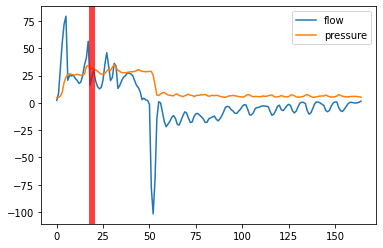

In [ ]:
import matplotlib.pyplot as plt
f,=plt.plot(abdataset[131:296,0],label='flow')
p,=plt.plot(abdataset[131:296,1],label='pressure')
plt.legend(handles=[f,p])
plt.axvline(counter[0],c='r')
plt.axvline(counter[1],c='r')
plt.axvline(counter[2],c='r')

plt.show()